Useful Captum Resources:

https://captum.ai/api/utilities.html

https://captum.ai/api/guided_grad_cam.html

https://github.com/pytorch/captum

In [1]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from multiprocessing import Pool


import torchvision
from torchvision import models as tvmodels
from torchsummary import summary

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.models as torchvisionmodels

import os
import numpy as np
import cv2
import argparse
import sys

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import itertools
import more_itertools

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from captum.attr import LayerGradCam
from captum.attr import visualization
from PIL import Image
import shutil

import numpy as np
from dask_image.imread import imread
from dask_image import ndfilters, ndmorph, ndmeasure
import matplotlib.pyplot as plt
from dask_image import ndmeasure

from operator import itemgetter

In [2]:
from model import resnet
from model.utils import load_filtered_state_dict, SaveBestModel, AverageMeter, accuracy
model = resnet.ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 2)
checkpoint = torch.load('cyberbullying-pytorch/models/cyberbullying/epoch_8.pkl')
load_filtered_state_dict(model, checkpoint, ignore_layer=[], reverse=True)
transform_test = transforms.Compose([transforms.Resize(320),
        transforms.RandomCrop(299), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

good_img_transform = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = {0:'cyberbullying', 1:'non_cyberbullying'}

test_path = 'cyberbullying/test'
testset = torchvision.datasets.ImageFolder(test_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=True, num_workers=2)

model.to(device)
model.eval()
#model.load_state_dict(checkpoint, strict=False)

320 320


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# This is to reverse the normalization done to the images that centered them around imagenet mean and std
# The invTrans should be used on images before saving them.
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])



# We want to make an array of -1 and 0. -1 are pixels we want to obfuscate.
# Attributions with positive values are areas we want to obfuscate
# Change positive attributions to -1 value so that the we black out this part
# This is to change the attributions to 0 or 1 values
def attribution_processor(attribution):
    attr_np = attribution.detach().squeeze().cpu().numpy()
    attr_np_sorted = np.sort(attr_np, axis=None)
    #This threshold obfuscates the top 10% of attribution scores
    top_attr_score_percentile = 0.10
    array_size = 299*299
    sorted_array_index = round(array_size*top_attr_score_percentile)
    threshold = attr_np_sorted[-sorted_array_index]
    
    #Convert pytorch tensor to numpy
    #threshold = attribution.mean().detach().cpu().numpy()
    #threshold = 0.05
    #Convert values greater than zero to 0 so that these don't impact the final image when the attributions are combined with the original image
    attr_final = attr_np
    row_counter = 0
    column_counter = 0
    for row in attr_final:
        for cell in row:
            if cell > threshold:
                attr_final[row_counter, column_counter] = -1
                column_counter +=1
            if cell <= threshold:
                attr_final[row_counter, column_counter] = 0
                column_counter +=1
        row_counter += 1
        column_counter = 0
    attr_final = torch.tensor(attr_final)
    attr_final = attr_final.unsqueeze(0)
    attr_final = attr_final.unsqueeze(0)
    return attr_final

def attribution_processor_gradual(attribution, percentile):
    attr_np = attribution.detach().squeeze().cpu().numpy()
    attr_np_sorted = np.sort(attr_np, axis=None)
    #This threshold obfuscates the top 10% of attribution scores
    top_attr_score_percentile = percentile
    array_size = 299*299
    sorted_array_index = round(array_size*top_attr_score_percentile)
    threshold = attr_np_sorted[-sorted_array_index]
    
    #Convert pytorch tensor to numpy
    #threshold = attribution.mean().detach().cpu().numpy()
    #threshold = 0.05
    #Convert values greater than zero to 0 so that these don't impact the final image when the attributions are combined with the original image
    attr_final = attr_np
    row_counter = 0
    column_counter = 0
    for row in attr_final:
        for cell in row:
            if cell > threshold:
                attr_final[row_counter, column_counter] = -1
                column_counter +=1
            if cell <= threshold:
                attr_final[row_counter, column_counter] = 0
                column_counter +=1
        row_counter += 1
        column_counter = 0
    attr_final = torch.tensor(attr_final)
    attr_final = attr_final.unsqueeze(0)
    attr_final = attr_final.unsqueeze(0)
    return attr_final



In [4]:
def Gradual_Grad_CAM_masking(model, Grad_CAM_layer, image, SMU_label_val, num_attr_regions):
    # Create a list to hold each stage of the image. From the unobfuscated image, to each stage of obfuscation
    image_stages = []
    attribution_regions = []
    num_pixels_obfuscated = []
    total_attribution = []
    
    # Model prediction on original image
    outputs = model(image.to(device)).cpu()
    _, predicted = outputs.max(1)
    orig_pred_val = predicted.item()
    
    # Original Image
    inv_tensor_original_img = invTrans(images)
    image_stages.append(inv_tensor_original_img.to(device))
    #attribution_regions.append([])
    

    for i in range(num_attr_regions + 1):
        # Obfuscate the most recent image appended to image_stages
        current_image_stage = good_img_transform(image_stages[0])
        current_image_stage = current_image_stage.to(device)
        layer_gc = LayerGradCam(model, Grad_CAM_layer)
        attribution = layer_gc.attribute(current_image_stage, orig_pred_val)
        transform = T.Resize(size = (299, 299))
        attribution = transform(attribution)
        this_attribution = attribution_processor_gradual(attribution, (i+1)*0.05)
        #print(torch.count_nonzero(this_attribution))
        
        total_attribution.append(this_attribution)
        print(torch.count_nonzero(total_attribution[-1]))
        
        obfuscated_image = current_image_stage + this_attribution.to(device) * 1000
        obfuscated_image = invTrans(obfuscated_image)
        image_stages.append(obfuscated_image)
    

    image_stages = image_stages[:-1]
    total_attribution = total_attribution[:-1]
    
    for f in range(num_attr_regions):
        # Get the specific region of the attribution from each stage of obfuscation by finding the difference between...
        #...the image stage we are at currently and the previous image stage. The pixels that are different are the...
        #...attributions for this specific stage
        # The attribution_regions tensor is of size (1,3,224,224)
        if f == 0:
            #print(torch.count_nonzero(total_attribution[0]))
            attribution_regions.append(total_attribution[0])
            num_obf = torch.count_nonzero(total_attribution[0])
            num_pixels_obfuscated.append(num_obf)
            
        if f > 0:
            previous_attribution = total_attribution[f-1].squeeze().squeeze().cpu().numpy()
            current_attribution = total_attribution[f].squeeze().squeeze().cpu().numpy()
            #print(torch.count_nonzero(total_attribution[-2]), 'versus', torch.count_nonzero(total_attribution[-1]))
            
            final_attribution = current_attribution
            row_counter = 0
            column_counter = 0
            for row in current_attribution:
                for cell in row:
                    if cell == 0:
                        final_attribution[row_counter, column_counter] = 0
                        column_counter +=1
                    elif cell == -1 and previous_attribution[row_counter, column_counter] == -1:
                        final_attribution[row_counter, column_counter] = 0
                        column_counter +=1
                    elif cell == -1 and previous_attribution[row_counter, column_counter] == 0:
                        final_attribution[row_counter, column_counter] = -1
                        column_counter +=1
                    else:
                        final_attribution[row_counter, column_counter] = 0
                        column_counter +=1
                row_counter += 1
                column_counter = 0
            final_attribution = torch.tensor(final_attribution)
            final_attribution.unsqueeze(0).unsqueeze(0)
            attribution_regions.append(final_attribution)
            num_obf = torch.count_nonzero(final_attribution)
            num_pixels_obfuscated.append(num_obf)
            
        # temp_image_stages_current = image_stages[-1].detach().squeeze().cpu().numpy()
        # temp_image_stages_previous = image_stages[-2].detach().squeeze().cpu().numpy()
        # current_attribution = temp_image_stages_current != temp_image_stages_previous
        # current_attribution = current_attribution * -1
        # current_attribution = torch.tensor(current_attribution)
        # current_attribution = current_attribution.unsqueeze(0)
        # print(torch.count_nonzero(current_attribution))
        #attribution_regions.append(current_attribution)
        

    # attribution_regions = attribution_regions[:-1]
    # num_pixels_obfuscated = num_pixels_obfuscated[:-1]

        
    return(image_stages, attribution_regions, num_pixels_obfuscated, total_attribution)

In [5]:
# Note: The input image should be go through the standard transforms we used for the model
# Note: The image_stages images do not need to be processed to have standard visual quality. They are ready to be saved
def iterative_Grad_CAM_masking(model, Grad_CAM_layer, image, SMU_label_val, num_iterations, top_attr_proportion):
    # Create a list to hold each stage of the image. From the unobfuscated image, to each stage of obfuscation
    image_stages = []
    attribution_regions = []
    num_pixels_obfuscated = []
    total_attribution = []
    
    # Model prediction on original image
    outputs = model(image.to(device)).cpu()
    _, predicted = outputs.max(1)
    orig_pred_val = predicted.item()
    
    # Original Image
    inv_tensor_original_img = invTrans(images)
    image_stages.append(inv_tensor_original_img.to(device))
    #attribution_regions.append([])
    
    
    for i in range(num_iterations):
        # Obfuscate the most recent image appended to image_stages
        current_image_stage = good_img_transform(image_stages[-1])
        current_image_stage = current_image_stage.to(device)
        layer_gc = LayerGradCam(model, Grad_CAM_layer)
        attribution = layer_gc.attribute(current_image_stage, orig_pred_val)
        transform = T.Resize(size = (299, 299))
        attribution = transform(attribution)
        attribution = attribution_processor_gradual(attribution, top_attr_proportion)
        #print(torch.count_nonzero(this_attribution))
        
        # Segment the attribution
        attr_for_seg = attribution.squeeze().detach().cpu().numpy()
        attr_for_seg = attr_for_seg * -1
        label_images, num_features = ndmeasure.label(attr_for_seg)
        num_features = num_features.compute()
        unique_values_in_attr = np.unique(label_images.compute())
        for feat in range(num_features):
            pixel_val = unique_values_in_attr[feat+1]
            current_attribution = (label_images == pixel_val) * -1
            current_attribution = current_attribution.astype(float)
            current_attribution = np.asarray(current_attribution)
            current_attribution = torch.tensor(current_attribution)
            current_attribution = current_attribution.unsqueeze(0)
            current_attribution = current_attribution.unsqueeze(0)
            
            attribution_regions.append(current_attribution)
        

        #print(torch.count_nonzero(total_attribution[-1]))
        
        obfuscated_image = current_image_stage + attribution.to(device) * 1000
        obfuscated_image = invTrans(obfuscated_image)
        image_stages.append(obfuscated_image)    
    
    num_attr_regions = len(attribution_regions)
    
    return(image_stages, attribution_regions, num_attr_regions)

def SMU_cost_function(num_total_pixels, num_obf_pixels, model, image, SMU_class_index):
    image = good_img_transform(image)
    logits = model(image).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    probs = probs[SMU_class_index]
    
    if num_obf_pixels == 0:
        score = 100
    
    else:
        score = (probs) + (num_obf_pixels / num_total_pixels)
    
    return score

In [6]:
def iterative_Grad_CAM_counterfactual_masking(iterative_Grad_CAM_masking_output, model, SMU_class_index):
    image_versions = []
    num_pixels_changed = []
    total_attribution = torch.zeros(1, 1, 299, 299)
    total_num_pixels = torch.numel(total_attribution)
    
    attribution_list = iterative_Grad_CAM_masking_output[1]
    powerset_list = list(more_itertools.powerset(attribution_list))
    powerset_list = [list(ele) for ele in powerset_list]
    num_versions = len(powerset_list)
    
    original_image = iterative_Grad_CAM_masking_output[0][0]
    image_versions.append(original_image)
    num_pixels_changed.append(0)
    

    for version in range(num_versions - 1):
        obfuscated_image = good_img_transform(original_image)
        total_attribution = torch.zeros(1, 1, 299, 299)
        for mask in range(len(powerset_list[version + 1])):
            total_attribution += powerset_list[version + 1][mask]
        
        num_changes = torch.count_nonzero(total_attribution).item()
        num_pixels_changed.append(num_changes)
        
        obfuscated_image = obfuscated_image.to(device) + total_attribution.to(device) * 1000
        obfuscated_image = invTrans(obfuscated_image)
        image_versions.append(obfuscated_image)
    
    index = 0
    cost_list = []
    for img in image_versions:
        
        cost = SMU_cost_function(num_total_pixels = total_num_pixels,
                                 num_obf_pixels = num_pixels_changed[index],
                                 model = model,
                                 image = img,
                                 SMU_class_index = SMU_class_index)
        
        index += 1
        cost_list.append(cost)
    
    information_for_each_image = []
    for index in range(len(image_versions)):
        image_list = []
        image_list.append(image_versions[index])
        image_list.append(total_num_pixels)
        image_list.append(num_pixels_changed[index])
        image_list.append(cost_list[index])
        information_for_each_image.append(image_list)
    return (information_for_each_image)
    
    #return ([image_versions, total_num_pixels, num_pixels_changed, cost_list])

def image_rankings(iterative_Grad_CAM_counterfactual_masking_output):
    #for idx in iterative_Grad_CAM_counterfactual_masking_output
    ranked_images = sorted(iterative_Grad_CAM_counterfactual_masking_output, key=itemgetter(3))
    return ranked_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])
tensor([1], device='cuda:0')


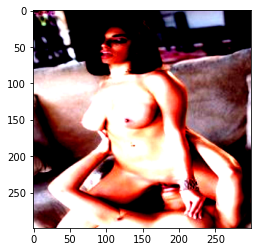

In [9]:
# This cell gets an example image and shows us the model prediction on the image that the model sees
# Good examples: 1, 2, 11, 68
# Examples with multiple regions of interest: 16
model.eval()
torch.manual_seed(0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(testloader, 1, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
plt.imshow( images.detach().cpu().squeeze().permute(1, 2, 0)  )

In [ ]:
# Samples to investigate further due to unnecessary additional obfuscations: 
# 16, 29, 21, 40, 50

## Cells below are just me experimenting with different attribution methods

In [15]:
from captum.attr import Lime

Predicted class:  4


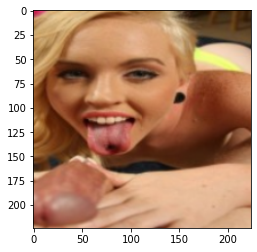

In [17]:
iter_obf_images_dir = './Obfuscated_data/unobfuscated_porn/'
img = Image.open(iter_obf_images_dir+'16'+'.png')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )

In [26]:
lime = Lime(model)
attr = lime.attribute(image_to_tensor, target=pred_val, n_samples=200, feature_mask=feature_mask.unsqueeze(0))
print(attr)

NameError: name 'feature_mask' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


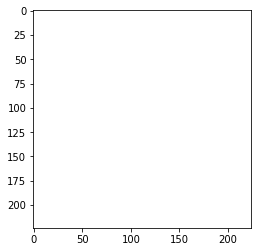

In [22]:
print(attr.size())
attr_mod = attr*1000
plt.imshow( attr_mod.detach().cpu().squeeze().permute(1, 2, 0)  )
#plt.imshow( attr.squeeze().detach().cpu().numpy() )

In [91]:
print(attr.min())

tensor(-0.0432, device='cuda:0')


In [28]:
from lime import lime_image
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

In [46]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_to_tensor.cpu(), 
                                         model, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

ValueError: only 2D color images are supported

In [251]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

image = img_as_float(io.imread(iter_obf_images_dir+'205'+'.png'))
segments = slic(image, n_segments = 250, sigma = 5)
fig = plt.figure("Superpixels -- %d segments%")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
plt.axis("off")

# show the plots
plt.show()

NameError: name 'iter_obf_images_dir' is not defined

In [1]:
iter_obf_images_dir = './Obfuscated_data/iterative_obfuscated_porn/'
img = Image.open(iter_obf_images_dir+'205'+'.png')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )

NameError: name 'Image' is not defined

In [2]:
iter_obf_images_dir = './Obfuscated_data/unobfuscated_porn/'
img = Image.open(iter_obf_images_dir+'205'+'.png')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )

NameError: name 'Image' is not defined

In [48]:
import more_itertools

Helpful LIME links

https://github.com/marcotcr/lime

https://lime-ml.readthedocs.io/en/latest/index.html

In [7]:
import lime
from lime import lime_image

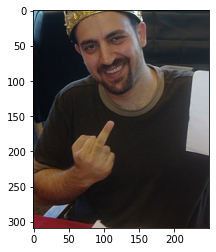

In [39]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('CB_example.jpg')
plt.imshow(img)

In [40]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [41]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t.to(device))

In [59]:
print(type(pill_transf(img)))
tensor_for_lime = invTrans(images)
print(type(img))
transform_to_PIL = T.ToPILImage()
tensor_for_lime = tensor_for_lime.squeeze()
print(tensor_for_lime.shape)

img_for_lime = transform_to_PIL(tensor_for_lime)
print(type(img_for_lime))

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
torch.Size([3, 299, 299])
<class 'PIL.Image.Image'>


In [42]:
probs = F.softmax(logits, dim=1)
print(probs)

tensor([[0.8446, 0.1554]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [43]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.CenterCrop(299)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [44]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [45]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

In [46]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict,
                                    
                                         top_labels=2, 
                                         hide_color=0,
                                         num_features = 5000,
                                         num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [60]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img_for_lime), 
                                         batch_predict,
                                    
                                         top_labels=2, 
                                         hide_color=0,
                                         num_features = 5000,
                                         num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
from skimage.segmentation import mark_boundaries

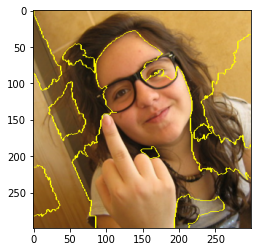

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=224, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

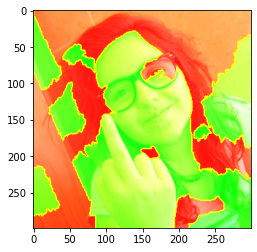

In [63]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=200, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [21]:
print(mask)

[[ 1  1  1 ... -1 -1 -1]
 [ 1  1  1 ... -1 -1 -1]
 [ 1  1  1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ...  1  1  1]
 [-1 -1 -1 ...  1  1  1]
 [-1 -1 -1 ...  1  1  1]]


Image segmentation

https://scipy-lectures.org/packages/scikit-image/index.html

In [69]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [89]:
print(model.layer4[-1])

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


In [91]:
print(model.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

# Blurring specified parts of image: Experiments

# Obfuscation from segmented features
SLIC Documentation: https://scikit-image.org/docs/dev/api/skimage.segmentation.html?highlight=slic#skimage.segmentation.slic

In [7]:
from skimage import segmentation
from pytorch_grad_cam import XGradCAM, GradCAM, FullGrad, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [8]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    target_layers = [model.layer4[-1]]
    cam = FullGrad(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

In [8]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    target_layers = [model.layer4[-1]]
    cam = XGradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)


In [8]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    #target_layers = [model.layer4[-1]]
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

In [98]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    #target_layers = [model.layer4[-1]]
    target_layers = [model.layer4[-1].conv3]
    cam = FullGrad(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

In [9]:
def segmentation_info(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


# I want to get the average attribution score for each segment
def cam_processor_for_segments(grayscale_cam_output, segments_slic):
    
    
    
    list_unique_regions = np.unique(segments_slic)
    region_attr_score = []
    final_region_attr_score = []
    num_pixels_in_region_list = []
    
    for i in (list_unique_regions):
        row_counter = 0
        column_counter = 0
        region_attr_score = []
        num_pixels_in_region = 0
        for row in grayscale_cam_output:
            for cell in row:
                current_score = grayscale_cam_output[row_counter, column_counter]
                current_region = segments_slic[row_counter, column_counter]
                if current_region == i:
                    region_attr_score.append(current_score)
                    num_pixels_in_region += 1
                column_counter +=1
            row_counter += 1
            column_counter = 0
        avg_score = np.mean(region_attr_score)
        final_region_attr_score.append(avg_score)
        num_pixels_in_region_list.append(num_pixels_in_region)
    
    unique_region_info = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(final_region_attr_score[i-1])
        image_list.append(num_pixels_in_region_list[i-1])
        image_list.append(np.sum(num_pixels_in_region_list))
        unique_region_info.append(image_list)
    
    return(unique_region_info)

In [10]:

def get_feature_masks(image, attributions, segments_slic):
    segments_slic_1 = segments_slic
    features = []
    for i in attributions:
        feature = np.where(i==segments_slic_1, 1, 0)
        features.append(feature)
        
    return(features)


def attribution_ranker(cam_processor_for_segments_output, num_top_attr):
    ranked_images = sorted(cam_processor_for_segments_output, key=itemgetter(1), reverse=True)
    top_ranked_features = []
    for i in range(num_top_attr):
        top_ranked_features.append(ranked_images[i][0])
        
    return top_ranked_features



In [11]:
def get_image_versions(image, features_list, model, SMU_class_index):
    image_versions = []
    num_pixels_changed = []
    total_attr_list = []

    powerset_list = list(more_itertools.powerset(features_list))
    powerset_list = [list(ele) for ele in powerset_list]
    num_versions = len(powerset_list)
    
    original_image = invTrans(image)
    image_versions.append(original_image)
    num_pixels_changed.append(0)
    total_attr_list.append(np.zeros((299, 299)))
    
    for version in range(num_versions - 1):
        obfuscated_image = image
        total_attribution = np.zeros((299, 299))
        total_num_pixels = total_attribution.size
        for mask in range(len(powerset_list[version + 1])):
            total_attribution += powerset_list[version + 1][mask]
            #print(np.max(powerset_list[version + 1][mask]))
        #print(np.max(total_attribution))
        num_changes = np.count_nonzero(total_attribution)
        num_pixels_changed.append(num_changes)
        total_attr_list.append(total_attribution)
        #print(num_changes)
        obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
        obfuscated_image = obfuscated_image.to(device)
        obfuscated_image = invTrans(obfuscated_image)
        
        image_versions.append(obfuscated_image)
    
    scores = []
    for i in range(num_versions):
        current_image = image_versions[i].to(device)
        #current_image = good_img_transform(current_image).to(device)
        score = SMU_cost_function(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed[i],
                                  model = model,
                                  image = current_image,
                                  SMU_class_index = SMU_class_index)
        scores.append(score)
    
    
    
    unique_image_info = []
    for i in range(num_versions):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        unique_image_info.append(image_list)
    
    
    return(unique_image_info)


def image_rankings(get_image_versions):
    #for idx in iterative_Grad_CAM_counterfactual_masking_output
    ranked_images = sorted(get_image_versions, key=itemgetter(3))
    
    return ranked_images



In [12]:
def blur_image_from_attribution(image, attribution_map):
    # attribution map is the attributions after being passed through the attribution processor
    # image is a tensor
    # will output the blurred image based on the attribution map
    
    
    #average_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    #avg = np.average(average_img)
    #blurred_img = cv2.GaussianBlur(image.squeeze().cpu().permute(1, 2, 0).numpy(), (181, 181), 0)
    avg = np.float32(-2.1179039478302)
    #avg_img = np.where(average_img > 9999, average_img, avg)
    
    #attribution_map = attribution_map.detach().squeeze().cpu().numpy()
    
    mask = [attribution_map, attribution_map, attribution_map]
    mask = np.array(mask)
    mask = mask.transpose(1,2,0)
    
    out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), avg)
    #out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), blurred_img)
    
    out = torch.tensor(out)
    out = out.permute(2,0,1)
    out = out.unsqueeze(0)
    
    return out

def SMU_cost_function(num_total_pixels, num_obf_pixels, model, image, SMU_class_index):
    image = good_img_transform(image)
    logits = model(image).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    probs = probs[SMU_class_index]
    
    if num_obf_pixels == 0:
        score = 1000
    
    else:
        # Punish for prob too far from 0.5. We want to obfuscate just enough to change model prediction
        score = probs + (num_obf_pixels / num_total_pixels)
    
    if probs > 0.50:
        score += 1
    if probs > 0.75:
        score += 1
    if probs > 0.80:
        score += 10**(1+probs)
    #print(probs)
    return score

def full_obfuscation_function(image, num_segments, num_top_attr, compactness, model, SMU_class_index):
    example_10 = get_grayscale_grad_cam(image = image)
    seg = segmentation_info(image = image, num_segments = num_segments, compactness = compactness)
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = num_top_attr)
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    ex_1 = get_image_versions(image = image, features_list = features_1, model = model, SMU_class_index = SMU_class_index)
    ranked = image_rankings(get_image_versions = ex_1)
    
    return ranked

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0])
tensor([0], device='cuda:0')
-1.9637812376022339


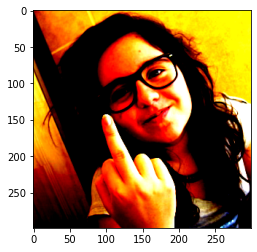

In [13]:
# This cell gets an example image and shows us the model prediction on the image that the model sees
# Porn samples: 1,2,3
# CB samples: 
model.eval()
torch.manual_seed(0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(testloader, 20, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
print(images.min().item())
plt.imshow( images.detach().cpu().squeeze().permute(1, 2, 0)  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


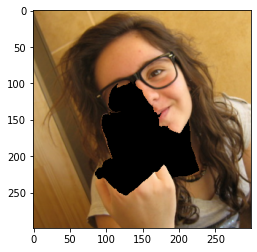

In [14]:
from skimage import segmentation
from pytorch_grad_cam import XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

example_10 = get_grayscale_grad_cam(image = images)
seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 8)
features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
ranked = image_rankings(get_image_versions = ex_1)
plt.imshow(ranked[0][0].detach().cpu().squeeze().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.012970774322968198


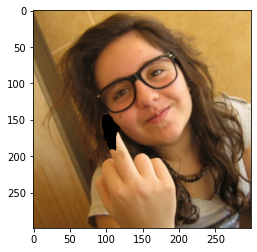

In [45]:
model.eval()
final_example = full_obfuscation_function(image = images,
                                          num_segments = 60,
                                          compactness = 30,
                                          num_top_attr = 10,
                                          model = model,
                                          SMU_class_index = 1)
print(final_example[0][3])
plt.imshow(final_example[0][0].detach().cpu().squeeze().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


256
0.4916932979405024
12308
89401
tensor(-2.1179, device='cuda:0')
[0.35402145981788635, 0.6459784507751465]
0.6459784507751465


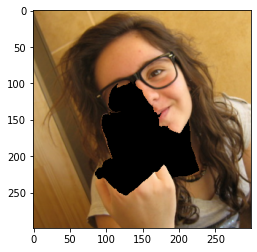

In [47]:
print(len(ranked))
index = 0
example = ranked[index][0]
print(ranked[index][3])
print(ranked[index][1])
print(ranked[index][2])
exam_img = good_img_transform(example)
print(exam_img.min())
logits = model(exam_img).cpu()
probs = F.softmax(logits, dim=1)
probs = probs.detach().cpu()
probs = probs.tolist()[0]
print(probs)
print(probs[1])
plt.imshow( example.detach().cpu().squeeze().permute(1, 2, 0)  )

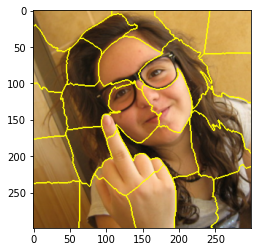

In [72]:
inv_img = invTrans(images)
img_np = inv_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = slic(img_np, n_segments=30, compactness=50,
                     start_label=1)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

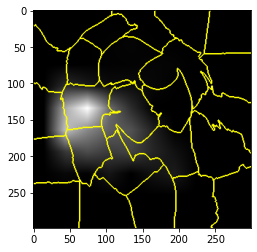

In [74]:
plt.imshow(segmentation.mark_boundaries(grayscale_cam, segments_slic))

[[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2
   2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
   2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
   4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
   4  4  4  4  4  4  4  4  4  4  4]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  

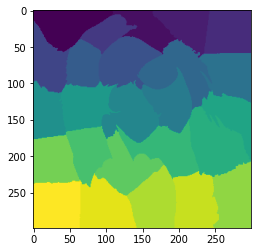

In [71]:
with np.printoptions(threshold=np.inf):
    print(seg[1])
plt.imshow(seg[1]*5)

In [69]:
print(seg[1].shape)

(299, 299)


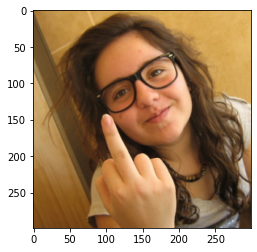

In [56]:
plt.imshow(inv_img.detach().cpu().squeeze().permute(1, 2, 0) )

In [50]:
print(top_attrs)

[14, 18, 12, 13, 19, 17, 20, 8]


In [63]:
for i in range(len(avg_attr_scores)):
    print(avg_attr_scores[i])

[1, 0.00032881123, 3740, 89401]
[2, 0.003032625, 2502, 89401]
[3, 3.1333435e-05, 2909, 89401]
[4, 0.0, 3596, 89401]
[5, 0.0052638035, 1956, 89401]
[6, 0.021227457, 3069, 89401]
[7, 0.020043874, 3929, 89401]
[8, 0.03262089, 2526, 89401]
[9, 0.009691077, 4658, 89401]
[10, 0.0, 3634, 89401]
[11, 0.009077272, 3243, 89401]
[12, 0.20728245, 4267, 89401]
[13, 0.16431202, 2747, 89401]
[14, 0.54155046, 3658, 89401]
[15, 0.0, 2954, 89401]
[16, 0.00017470976, 5021, 89401]
[17, 0.10031605, 4226, 89401]
[18, 0.2822304, 3151, 89401]
[19, 0.11194998, 3815, 89401]
[20, 0.08131999, 3467, 89401]
[21, 0.0, 3963, 89401]
[22, 0.013355009, 4158, 89401]
[23, 0.0048185764, 4016, 89401]
[24, 0.0033190157, 4147, 89401]
[25, 0.0012459373, 4049, 89401]


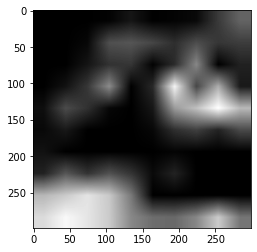

In [103]:
from pytorch_grad_cam import XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
input_tensor = exam_img.to(device)
targets = [ClassifierOutputTarget(1)]
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
#visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=T
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

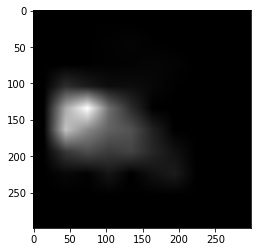

In [73]:
from pytorch_grad_cam import FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
input_tensor = images.to(device)
targets = [ClassifierOutputTarget(0)]
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
#visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=T
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

# Obfuscation Testing

In [17]:
# To test our algorithm with no region dilation (8 regions)
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 8)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs = probs[0]
        #print(probs)
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [18]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.9466666666666667
0.1273324310317185


In [19]:
# To test unlimited dilation on our algorithm (8 regions)
from scipy import ndimage
i = 0
n = 0
image_info_list = []
while i < 200:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 8)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        

        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        if probs > 0.5:
            example_attribution_map = ranked[0][4]
            dil = obfuscation_dilation(image = images,
                           attribution_map = example_attribution_map,
                           num_dilations = 5)
            ranked[0][0] = dil[0]
            ranked[0][1] = np.count_nonzero(dil[1])
            
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1079


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1107


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1111


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1117


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1122


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1127


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1131


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1135


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1145


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1156


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1166


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1171


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1172


In [20]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

1.0
0.1342168432120446


In [21]:
# To test our algorithm with no region dilation (6 regions)
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 6)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [22]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.8133333333333334
0.12185769734119305


In [23]:
# To test unlimited dilation on our algorithm (6 regions)
from scipy import ndimage
i = 0
n = 0
image_info_list = []
while i < 200:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 6)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        

        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        if probs > 0.5:
            example_attribution_map = ranked[0][4]
            dil = obfuscation_dilation(image = images,
                           attribution_map = example_attribution_map,
                           num_dilations = 5)
            ranked[0][0] = dil[0]
            ranked[0][1] = np.count_nonzero(dil[1])
            
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1079


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1107


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1111


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1117


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1122


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1127


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1131


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1135


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1145


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1156


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1166


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1171


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1172


In [24]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

1.0
0.1426355409894744


In [25]:
# To test our algorithm with no region dilation (4 regions)
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 4)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [26]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.6266666666666667
0.10036174092012394


In [27]:
# To test unlimited dilation on our algorithm (4 regions)
from scipy import ndimage
i = 0
n = 0
image_info_list = []
while i < 200:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 4)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        

        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        if probs > 0.5:
            example_attribution_map = ranked[0][4]
            dil = obfuscation_dilation(image = images,
                           attribution_map = example_attribution_map,
                           num_dilations = 5)
            ranked[0][0] = dil[0]
            ranked[0][1] = np.count_nonzero(dil[1])
            
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1079


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1107


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1111


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1117


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1122


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1127


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1131


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1135


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1145


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1156


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1166


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1171


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1172


In [28]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

1.0
0.1427013679936466


In [29]:
# To test limited dilation on our algorithm (8 regions)
from scipy import ndimage
i = 0
n = 0
image_info_list = []
while i < 200:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 8)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        

        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        if probs > 0.5:
            example_attribution_map = ranked[0][4]
            dil = obfuscation_dilation_limited(image = images,
                           attribution_map = example_attribution_map,
                           num_dilations = 5)
            ranked[0][0] = dil[0]
            ranked[0][1] = np.count_nonzero(dil[1])
            
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1079


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1107


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1111


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1117


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1122


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1127


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1131


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1135


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1145


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1156


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1166


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1171


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1172


In [30]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.995
0.13374867171508148


In [31]:
# To test limited dilation on our algorithm (6 regions)
from scipy import ndimage
i = 0
n = 0
image_info_list = []
while i < 200:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 6)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        

        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        if probs > 0.5:
            example_attribution_map = ranked[0][4]
            dil = obfuscation_dilation_limited(image = images,
                           attribution_map = example_attribution_map,
                           num_dilations = 5)
            ranked[0][0] = dil[0]
            ranked[0][1] = np.count_nonzero(dil[1])
            
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1079


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1107


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1111


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1117


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1122


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1127


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1131


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1135


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1145


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1156


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1166


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1171


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1172


In [32]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.99
0.14162056352837216


In [33]:
# To test limited dilation on our algorithm (4 regions)
from scipy import ndimage
i = 0
n = 0
image_info_list = []
while i < 200:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 4)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        

        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        if probs > 0.5:
            example_attribution_map = ranked[0][4]
            dil = obfuscation_dilation_limited(image = images,
                           attribution_map = example_attribution_map,
                           num_dilations = 5)
            ranked[0][0] = dil[0]
            ranked[0][1] = np.count_nonzero(dil[1])
            
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1079


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1107


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1111


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1117


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1122


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1127


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1131


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1135


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1145


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1156


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1166


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1171


/home/ocistudent/ocistudent/envs/SMU/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


index: 1172


In [34]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.995
0.1420419793962036


In [17]:
print(len(image_info_list))

200


In [19]:
print(image_info_list[0][1])

10608


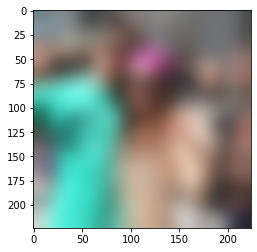

In [276]:
blurred_img = cv2.GaussianBlur(images.squeeze().cpu().permute(1, 2, 0).numpy(), (61, 61), 0)
out = torch.tensor(blurred_img)
out = out.permute(2,0,1)
out = out.unsqueeze(0)
out = invTrans(out)
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0) )
plt.savefig('full_blur_survey.png', bbox_inches='tight',pad_inches = 0)

8


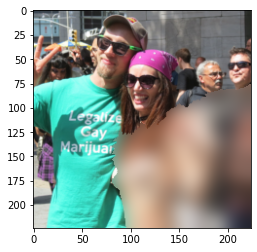

In [261]:
print(len(features_1))
total_attribution = np.zeros((299, 299))
for feature in range(len(features_1)):
    total_attribution += features_1[feature]
    
blurred = cv2.GaussianBlur(images.squeeze().cpu().permute(1, 2, 0).numpy(), (61, 61), 0)
    
mask = [total_attribution, total_attribution, total_attribution]
mask = np.array(mask)
mask = mask.transpose(1,2,0)

partial_blur = np.where(mask==np.array([0, 0, 0]), images.squeeze().cpu().permute(1, 2, 0).numpy(), blurred)

# obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
#                                                        attribution_map = total_attribution)

partial_blur = torch.tensor(partial_blur)
partial_blur = partial_blur.permute(2,0,1)
partial_blur = partial_blur.unsqueeze(0)
partial_blur = invTrans(partial_blur)
plt.imshow(partial_blur.detach().cpu().squeeze().permute(1, 2, 0) )

In [65]:
for feature in range(len(features_1)):
    print(feature)

0
1
2
3
4
5
6
7


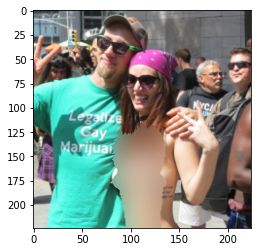

In [271]:
total_attribution = features_1[7] + features_1[4]
blurred = cv2.GaussianBlur(images.squeeze().cpu().permute(1, 2, 0).numpy(), (91, 91), 0)
    
mask = [total_attribution, total_attribution, total_attribution]
mask = np.array(mask)
mask = mask.transpose(1,2,0)

partial_blur = np.where(mask==np.array([0, 0, 0]), images.squeeze().cpu().permute(1, 2, 0).numpy(), blurred)

# obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
#                                                        attribution_map = total_attribution)

partial_blur = torch.tensor(partial_blur)
partial_blur = partial_blur.permute(2,0,1)
partial_blur = partial_blur.unsqueeze(0)
partial_blur = invTrans(partial_blur)
plt.imshow(partial_blur.detach().cpu().squeeze().permute(1, 2, 0) )
plt.savefig('partial_blur_survey.png')

Predicted class:  0


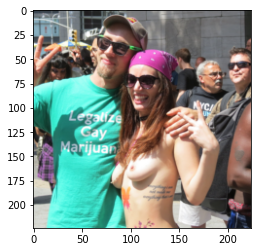

In [272]:
img = Image.open('survey_img.png')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)
images = image_to_tensor

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )
plt.savefig('unblurred_survey.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


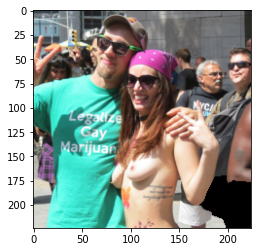

In [241]:
example_10 = get_grayscale_grad_cam(image = images)
seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 8)
features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 1)
ranked = image_rankings(get_image_versions = ex_1)
plt.imshow(ranked[0][0].detach().cpu().squeeze().permute(1, 2, 0))

In [242]:
print(len(features_1))

8


Predicted class:  0


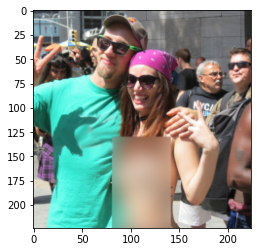

In [275]:
img = Image.open('Survey Image blurred.png').convert('RGB')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)
images = image_to_tensor

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )
plt.savefig('partial_blur_survey.png', bbox_inches='tight',pad_inches = 0)

In [115]:
from scipy import ndimage
print(ex_1[0][4].max())
example_attribution_map = ranked[0][4]


0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


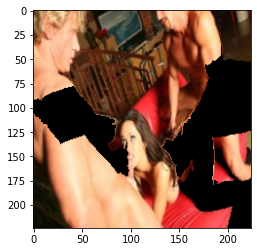

In [116]:
obfusc = blur_image_from_attribution(image = images,
                                                       attribution_map = example_attribution_map)
obfusc = obfusc.to(device)
obfusc = invTrans(obfusc)
plt.imshow( obfusc.detach().cpu().squeeze().permute(1, 2, 0)  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


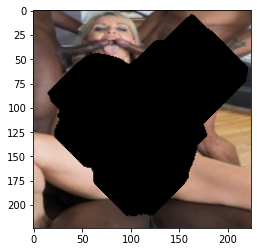

In [64]:
def obfuscation_dilation(image, attribution_map, num_dilations):
    # Takes in the original input image
    attr_map = attribution_map
    attr_map = ndimage.binary_dilation(input = attr_map, iterations = num_dilations)
    obf_image = blur_image_from_attribution(image = image,
                                            attribution_map = attr_map)
    
    logits = model(obf_image.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    #Change probs[int] to int = SMU class index
    while probs[0] > 0.5:
        attr_map = ndimage.binary_dilation(input = attr_map, iterations = num_dilations)
        obf_image = blur_image_from_attribution(image = image,
                                            attribution_map = attr_map)
        logits = model(obf_image.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
    
    obf_image = invTrans(obf_image)
    
    return obf_image, attr_map, probsfrom scipy import ndimage
example_attribution_map_2 = ndimage.binary_dilation(input = example_attribution_map, iterations =30)
obfusc = blur_image_from_attribution(image = images,
                                                       attribution_map = example_attribution_map_2)
obfusc = obfusc.to(device)
obfusc = invTrans(obfusc)
plt.imshow( obfusc.detach().cpu().squeeze().permute(1, 2, 0)  )

In [117]:
ev = good_img_transform(obfusc).to(device)
logits = model(ev).cpu()
probs = F.softmax(logits, dim=1)
probs = probs.detach().cpu()
probs = probs.tolist()[0]
print(probs)

[0.05422545224428177, 0.9457745552062988]


In [15]:
def obfuscation_dilation(image, attribution_map, num_dilations):
    # Takes in the original input image
    attr_map = attribution_map
    attr_map = ndimage.binary_dilation(input = attr_map, iterations = num_dilations)
    obf_image = blur_image_from_attribution(image = image,
                                            attribution_map = attr_map)
    
    logits = model(obf_image.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    #Change probs[int] to int = SMU class index
    while probs[0] > 0.5:
        attr_map = ndimage.binary_dilation(input = attr_map, iterations = num_dilations)
        obf_image = blur_image_from_attribution(image = image,
                                            attribution_map = attr_map)
        logits = model(obf_image.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
    
    obf_image = invTrans(obf_image)
    
    return obf_image, attr_map, probs

In [16]:
def obfuscation_dilation_limited(image, attribution_map, num_dilations):
    # Takes in the original input image
    attr_map = attribution_map
    attr_map = ndimage.binary_dilation(input = attr_map, iterations = num_dilations)
    obf_image = blur_image_from_attribution(image = image,
                                            attribution_map = attr_map)
    
    logits = model(obf_image.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    #Change probs[int] to int = SMU class index
    while probs[0] > 0.5:
        attr_map = ndimage.binary_dilation(input = attr_map, iterations = num_dilations)
        obf_image = blur_image_from_attribution(image = image,
                                            attribution_map = attr_map)
        logits = model(obf_image.to(device)).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        
        mask_prop = np.count_nonzero(attr_map) / (299*299)
        if mask_prop > 0.5:
            break
        
        # if proportion of mask is > some value then break
    
    
    
    obf_image = invTrans(obf_image)
    
    return obf_image, attr_map, probs

[0.6033678650856018, 0.3966321647167206]
0.3966321647167206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


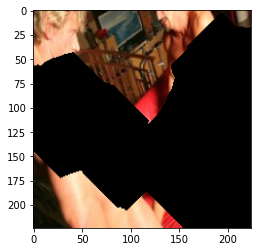

In [120]:

dil = obfuscation_dilation(image = images,
                           attribution_map = example_attribution_map,
                           num_dilations = 5)
print(dil[2])
print(dil[2][1])
plt.imshow( dil[0].detach().cpu().squeeze().permute(1, 2, 0)  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


91.45343115611527


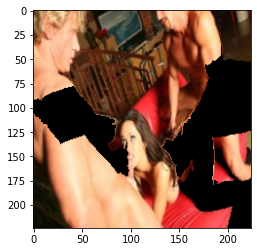

In [121]:
print(ranked[0][3])
plt.imshow(ranked[0][0].detach().cpu().squeeze().permute(1, 2, 0))

In [123]:
x1 = np.count_nonzero(dil[1])
print(x1)

31797


In [14]:

def CAM_attribution_processor(attribution, percentile):
    #attr_np = attribution.detach().squeeze().cpu().numpy()
    attr_np_sorted = np.sort(attribution, axis=None)
    #This threshold obfuscates the top 10% of attribution scores
    top_attr_score_percentile = percentile
    array_size = 299*299
    sorted_array_index = round(array_size*top_attr_score_percentile)
    threshold = attr_np_sorted[-sorted_array_index]
    
    #Convert pytorch tensor to numpy
    #threshold = attribution.mean().detach().cpu().numpy()
    #threshold = 0.05
    #Convert values greater than zero to 0 so that these don't impact the final image when the attributions are combined with the original image
    attr_final = attribution
    row_counter = 0
    column_counter = 0
    for row in attr_final:
        for cell in row:
            if cell > threshold:
                attr_final[row_counter, column_counter] = -1
                column_counter +=1
            if cell <= threshold:
                attr_final[row_counter, column_counter] = 0
                column_counter +=1
        row_counter += 1
        column_counter = 0
    # attr_final = torch.tensor(attr_final)
    # attr_final = attr_final.unsqueeze(0)
    # attr_final = attr_final.unsqueeze(0)
    return attr_final

In [20]:
example_attribution_1 = get_grayscale_grad_cam(image = images)
CAM_attr_1 =  CAM_attribution_processor(attribution = example_attribution_1, percentile = 0.20)

In [21]:
print(CAM_attr_1.shape)
print(np.count_nonzero(CAM_attr_1))

(299, 299)
17879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9425337910652161


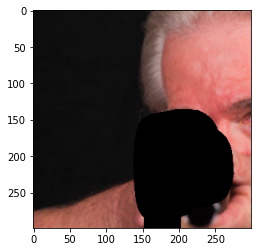

In [22]:
obfusc = blur_image_from_attribution(image = images,
                                                       attribution_map = CAM_attr_1)

logits = model(obfusc.to(device)).cpu()
probs = F.softmax(logits, dim=1)
probs = probs.detach().cpu()
probs = probs.tolist()[0]
probs = probs[1]
print(probs)
obfusc = obfusc.to(device)
obfusc = invTrans(obfusc)
plt.imshow( obfusc.detach().cpu().squeeze().permute(1, 2, 0)  )

In [23]:
example_attribution_1 = get_grayscale_grad_cam(image = images)
CAM_attr_1 =  CAM_attribution_processor(attribution = example_attribution_1, percentile = 0.20)
obfusc = blur_image_from_attribution(image = images,
                                                       attribution_map = CAM_attr_1)
obfusc = obfusc.to(device)
obfusc = invTrans(obfusc)


example = obfusc
exam_img = good_img_transform(example)
logits = model(exam_img).cpu()
probs = F.softmax(logits, dim=1)
probs = probs.detach().cpu()
probs = probs.tolist()[0]
probs = probs[1]

num_pixels_obf = np.count_nonzero(CAM_attr_1)

In [15]:
# To test cam based masking methods
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_attribution_1 = get_grayscale_grad_cam(image = images)
        CAM_attr_1 =  CAM_attribution_processor(attribution = example_attribution_1, percentile = 0.20)
        obfusc = blur_image_from_attribution(image = images,
                                                       attribution_map = CAM_attr_1)
        obfusc = obfusc.to(device)
        obfusc = invTrans(obfusc)


        example = obfusc
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        #Change probs[int] to int = SMU class index
        image_info = []
        

        image_info.append(probs)
        
        num_pixels_obf = np.count_nonzero(CAM_attr_1)
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [16]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.7333333333333333
0.1999436993620504


In [17]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    target_layers = [model.layer4[-1]]
    cam = FullGrad(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

In [18]:
# To test cam based masking methods
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_attribution_1 = get_grayscale_grad_cam(image = images)
        CAM_attr_1 =  CAM_attribution_processor(attribution = example_attribution_1, percentile = 0.20)
        obfusc = blur_image_from_attribution(image = images,
                                                       attribution_map = CAM_attr_1)
        obfusc = obfusc.to(device)
        obfusc = invTrans(obfusc)


        example = obfusc
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        #Change probs[int] to int = SMU class index
        image_info = []
        

        image_info.append(probs)
        
        num_pixels_obf = np.count_nonzero(CAM_attr_1)
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515


index: 516
index: 521
index: 522
index: 527
index: 542
index: 544
index: 549
index: 558
index: 559
index: 566
index: 574
index: 581
index: 594
index: 595
index: 600
index: 614
index: 618
index: 619
index: 620
index: 623
index: 634
index: 636
index: 646
index: 654
index: 658
index: 661
index: 662
index: 663
index: 666
index: 667
index: 668
index: 670
index: 675
index: 678
index: 685
index: 691
index: 695
index: 698
index: 700
index: 709
index: 712
index: 715
index: 721
index: 725
index: 730
index: 731
index: 745
index: 765
index: 775
index: 777
index: 783
index: 784
index: 792
index: 794
index: 796
index: 798
index: 809
index: 812
index: 818
index: 828
index: 829
index: 843
index: 851


In [19]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.84
0.19998657733134975


In [20]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    #target_layers = [model.layer4[-1]]
    target_layers = [model.layer4[-1].conv3]
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

In [21]:
# To test cam based masking methods
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        example_attribution_1 = get_grayscale_grad_cam(image = images)
        CAM_attr_1 =  CAM_attribution_processor(attribution = example_attribution_1, percentile = 0.20)
        obfusc = blur_image_from_attribution(image = images,
                                                       attribution_map = CAM_attr_1)
        obfusc = obfusc.to(device)
        obfusc = invTrans(obfusc)


        example = obfusc
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        #Change probs[int] to int = SMU class index
        image_info = []
        

        image_info.append(probs)
        
        num_pixels_obf = np.count_nonzero(CAM_attr_1)
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [22]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.06
0.1999513055409522


In [4]:
# Lime explainability processing
import lime
from lime import lime_image

## LIME Evaluations

In [9]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [10]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)



def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.CenterCrop(299)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf  

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def black_image_from_attribution_lime(image, attribution_map):
    # attribution map is the attributions after being passed through the attribution processor
    # image is a tensor
    # will output the blurred image based on the attribution map
    
    
    #average_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    #avg = np.average(average_img)
    #blurred_img = cv2.GaussianBlur(image.squeeze().cpu().permute(1, 2, 0).numpy(), (181, 181), 0)
    avg = np.float32(-2.1179039478302)
    #avg_img = np.where(average_img > 9999, average_img, avg)
    
    #attribution_map = attribution_map.detach().squeeze().cpu().numpy()
    
    mask = [attribution_map, attribution_map, attribution_map]
    mask = np.array(mask)
    mask = mask.transpose(1,2,0)
    
    out = np.where(mask==np.array([-1, -1, -1]), image.squeeze().cpu().permute(1, 2, 0).numpy(), avg)
    #out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), blurred_img)
    
    out = torch.tensor(out)
    out = out.permute(2,0,1)
    out = out.unsqueeze(0)
    
    
    return out

In [12]:


tensor_for_lime = invTrans(images)
transform_to_PIL = T.ToPILImage()
tensor_for_lime = tensor_for_lime.squeeze()
img_for_lime = transform_to_PIL(tensor_for_lime)
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
test_pred = batch_predict([img_for_lime])
test_pred.squeeze().argmax()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img_for_lime), 
                                         batch_predict,
                                    
                                         top_labels=2, 
                                         hide_color=0,
                                         num_features = 5000,
                                         num_samples=100)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=224, hide_rest=False)



  0%|          | 0/100 [00:00<?, ?it/s]

0

  0%|          | 0/100 [00:00<?, ?it/s]

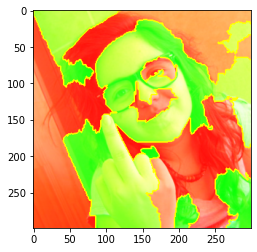

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=200, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [14]:
print(mask)
print(type(mask))

[[-1  1  1 ... -1 -1 -1]
 [-1  1  1 ... -1 -1 -1]
 [-1  1  1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ...  1  1  1]
 [-1 -1 -1 ...  1  1  1]
 [-1 -1 -1 ...  1  1  1]]
<class 'numpy.ndarray'>


In [23]:
def black_image_from_attribution_lime(image, attribution_map):
    # attribution map is the attributions after being passed through the attribution processor
    # image is a tensor
    # will output the blurred image based on the attribution map
    
    
    #average_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    #avg = np.average(average_img)
    #blurred_img = cv2.GaussianBlur(image.squeeze().cpu().permute(1, 2, 0).numpy(), (181, 181), 0)
    avg = np.float32(-2.1179039478302)
    #avg_img = np.where(average_img > 9999, average_img, avg)
    
    #attribution_map = attribution_map.detach().squeeze().cpu().numpy()
    
    mask = [attribution_map, attribution_map, attribution_map]
    mask = np.array(mask)
    mask = mask.transpose(1,2,0)
    
    out = np.where(mask==np.array([-1, -1, -1]), image.squeeze().cpu().permute(1, 2, 0).numpy(), avg)
    #out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), blurred_img)
    
    out = torch.tensor(out)
    out = out.permute(2,0,1)
    out = out.unsqueeze(0)
    
    
    return out

In [24]:
lime_img_output = black_image_from_attribution_lime(image = tensor_for_lime, attribution_map = mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


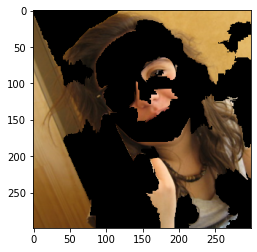

In [25]:
plt.imshow(lime_img_output.detach().cpu().squeeze().permute(1, 2, 0))

In [27]:
lime_img_output_for_model = good_img_transform(lime_img_output)
model.eval()
print(model(lime_img_output_for_model.to(device)))

tensor([[-1.9955,  2.6207]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [31]:
pix_obf = np.count_nonzero(mask == 1)


42796
46605


In [33]:
# To test LIME
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        
        
        
        tensor_for_lime = invTrans(images)
        transform_to_PIL = T.ToPILImage()
        tensor_for_lime = tensor_for_lime.squeeze()
        img_for_lime = transform_to_PIL(tensor_for_lime)
        pill_transf = get_pil_transform()
        preprocess_transform = get_preprocess_transform()
        test_pred = batch_predict([img_for_lime])
        test_pred.squeeze().argmax()

        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(np.array(img_for_lime), 
                                         batch_predict,
                                    
                                         top_labels=2, 
                                         hide_color=0,
                                         num_features = 5000,
                                         num_samples=100)

        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=224, hide_rest=False)
        
        lime_img_output = black_image_from_attribution_lime(image = tensor_for_lime, attribution_map = mask)
        model.eval()
        lime_img_output_for_model = good_img_transform(lime_img_output).to(device)
        
        logits = model(lime_img_output_for_model).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        probs = probs[0]
        #Change probs[int] to int = SMU class index
        image_info = []
        
        image_info.append(probs)
        num_pixels_obf = np.count_nonzero(mask == 1)
        image_info.append(num_pixels_obf)
        image_info_list.append(image_info)
        
        
    n += 1

index: 12


  0%|          | 0/100 [00:00<?, ?it/s]

index: 20


  0%|          | 0/100 [00:00<?, ?it/s]

index: 23


  0%|          | 0/100 [00:00<?, ?it/s]

index: 30


  0%|          | 0/100 [00:00<?, ?it/s]

index: 37


  0%|          | 0/100 [00:00<?, ?it/s]

index: 38


  0%|          | 0/100 [00:00<?, ?it/s]

index: 47


  0%|          | 0/100 [00:00<?, ?it/s]

index: 52


  0%|          | 0/100 [00:00<?, ?it/s]

index: 57


  0%|          | 0/100 [00:00<?, ?it/s]

index: 61


  0%|          | 0/100 [00:00<?, ?it/s]

index: 81


  0%|          | 0/100 [00:00<?, ?it/s]

index: 87


  0%|          | 0/100 [00:00<?, ?it/s]

index: 90


  0%|          | 0/100 [00:00<?, ?it/s]

index: 94


  0%|          | 0/100 [00:00<?, ?it/s]

index: 100


  0%|          | 0/100 [00:00<?, ?it/s]

index: 102


  0%|          | 0/100 [00:00<?, ?it/s]

index: 104


  0%|          | 0/100 [00:00<?, ?it/s]

index: 109


  0%|          | 0/100 [00:00<?, ?it/s]

index: 115


  0%|          | 0/100 [00:00<?, ?it/s]

index: 120


  0%|          | 0/100 [00:00<?, ?it/s]

index: 123


  0%|          | 0/100 [00:00<?, ?it/s]

index: 127


  0%|          | 0/100 [00:00<?, ?it/s]

index: 128


  0%|          | 0/100 [00:00<?, ?it/s]

index: 129


  0%|          | 0/100 [00:00<?, ?it/s]

index: 138


  0%|          | 0/100 [00:00<?, ?it/s]

index: 151


  0%|          | 0/100 [00:00<?, ?it/s]

index: 155


  0%|          | 0/100 [00:00<?, ?it/s]

index: 172


  0%|          | 0/100 [00:00<?, ?it/s]

index: 174


  0%|          | 0/100 [00:00<?, ?it/s]

index: 179


  0%|          | 0/100 [00:00<?, ?it/s]

index: 180


  0%|          | 0/100 [00:00<?, ?it/s]

index: 183


  0%|          | 0/100 [00:00<?, ?it/s]

index: 185


  0%|          | 0/100 [00:00<?, ?it/s]

index: 189


  0%|          | 0/100 [00:00<?, ?it/s]

index: 193


  0%|          | 0/100 [00:00<?, ?it/s]

index: 201


  0%|          | 0/100 [00:00<?, ?it/s]

index: 218


  0%|          | 0/100 [00:00<?, ?it/s]

index: 222


  0%|          | 0/100 [00:00<?, ?it/s]

index: 226


  0%|          | 0/100 [00:00<?, ?it/s]

index: 242


  0%|          | 0/100 [00:00<?, ?it/s]

index: 243


  0%|          | 0/100 [00:00<?, ?it/s]

index: 246


  0%|          | 0/100 [00:00<?, ?it/s]

index: 248


  0%|          | 0/100 [00:00<?, ?it/s]

index: 257


  0%|          | 0/100 [00:00<?, ?it/s]

index: 271


  0%|          | 0/100 [00:00<?, ?it/s]

index: 292


  0%|          | 0/100 [00:00<?, ?it/s]

index: 299


  0%|          | 0/100 [00:00<?, ?it/s]

index: 304


  0%|          | 0/100 [00:00<?, ?it/s]

index: 312


  0%|          | 0/100 [00:00<?, ?it/s]

index: 316


  0%|          | 0/100 [00:00<?, ?it/s]

index: 317


  0%|          | 0/100 [00:00<?, ?it/s]

index: 324


  0%|          | 0/100 [00:00<?, ?it/s]

index: 332


  0%|          | 0/100 [00:00<?, ?it/s]

index: 343


  0%|          | 0/100 [00:00<?, ?it/s]

index: 344


  0%|          | 0/100 [00:00<?, ?it/s]

index: 359


  0%|          | 0/100 [00:00<?, ?it/s]

index: 362


  0%|          | 0/100 [00:00<?, ?it/s]

index: 370


  0%|          | 0/100 [00:00<?, ?it/s]

index: 380


  0%|          | 0/100 [00:00<?, ?it/s]

index: 390


  0%|          | 0/100 [00:00<?, ?it/s]

index: 391


  0%|          | 0/100 [00:00<?, ?it/s]

index: 392


  0%|          | 0/100 [00:00<?, ?it/s]

index: 412


  0%|          | 0/100 [00:00<?, ?it/s]

index: 414


  0%|          | 0/100 [00:00<?, ?it/s]

index: 417


  0%|          | 0/100 [00:00<?, ?it/s]

index: 425


  0%|          | 0/100 [00:00<?, ?it/s]

index: 428


  0%|          | 0/100 [00:00<?, ?it/s]

index: 433


  0%|          | 0/100 [00:00<?, ?it/s]

index: 437


  0%|          | 0/100 [00:00<?, ?it/s]

index: 439


  0%|          | 0/100 [00:00<?, ?it/s]

index: 443


  0%|          | 0/100 [00:00<?, ?it/s]

index: 444


  0%|          | 0/100 [00:00<?, ?it/s]

index: 453


  0%|          | 0/100 [00:00<?, ?it/s]

index: 459


  0%|          | 0/100 [00:00<?, ?it/s]

index: 464


  0%|          | 0/100 [00:00<?, ?it/s]

index: 466


  0%|          | 0/100 [00:00<?, ?it/s]

index: 474


  0%|          | 0/100 [00:00<?, ?it/s]

index: 481


  0%|          | 0/100 [00:00<?, ?it/s]

index: 484


  0%|          | 0/100 [00:00<?, ?it/s]

index: 485


  0%|          | 0/100 [00:00<?, ?it/s]

index: 486


  0%|          | 0/100 [00:00<?, ?it/s]

index: 489


  0%|          | 0/100 [00:00<?, ?it/s]

index: 494


  0%|          | 0/100 [00:00<?, ?it/s]

index: 500


  0%|          | 0/100 [00:00<?, ?it/s]

index: 502


  0%|          | 0/100 [00:00<?, ?it/s]

index: 511


  0%|          | 0/100 [00:00<?, ?it/s]

index: 515


  0%|          | 0/100 [00:00<?, ?it/s]

index: 516


  0%|          | 0/100 [00:00<?, ?it/s]

index: 521


  0%|          | 0/100 [00:00<?, ?it/s]

index: 522


  0%|          | 0/100 [00:00<?, ?it/s]

index: 527


  0%|          | 0/100 [00:00<?, ?it/s]

index: 542


  0%|          | 0/100 [00:00<?, ?it/s]

index: 544


  0%|          | 0/100 [00:00<?, ?it/s]

index: 549


  0%|          | 0/100 [00:00<?, ?it/s]

index: 558


  0%|          | 0/100 [00:00<?, ?it/s]

index: 559


  0%|          | 0/100 [00:00<?, ?it/s]

index: 566


  0%|          | 0/100 [00:00<?, ?it/s]

index: 574


  0%|          | 0/100 [00:00<?, ?it/s]

index: 581


  0%|          | 0/100 [00:00<?, ?it/s]

index: 594


  0%|          | 0/100 [00:00<?, ?it/s]

index: 595


  0%|          | 0/100 [00:00<?, ?it/s]

index: 600


  0%|          | 0/100 [00:00<?, ?it/s]

index: 614


  0%|          | 0/100 [00:00<?, ?it/s]

index: 618


  0%|          | 0/100 [00:00<?, ?it/s]

index: 619


  0%|          | 0/100 [00:00<?, ?it/s]

index: 620


  0%|          | 0/100 [00:00<?, ?it/s]

index: 623


  0%|          | 0/100 [00:00<?, ?it/s]

index: 634


  0%|          | 0/100 [00:00<?, ?it/s]

index: 636


  0%|          | 0/100 [00:00<?, ?it/s]

index: 646


  0%|          | 0/100 [00:00<?, ?it/s]

index: 654


  0%|          | 0/100 [00:00<?, ?it/s]

index: 658


  0%|          | 0/100 [00:00<?, ?it/s]

index: 661


  0%|          | 0/100 [00:00<?, ?it/s]

index: 662


  0%|          | 0/100 [00:00<?, ?it/s]

index: 663


  0%|          | 0/100 [00:00<?, ?it/s]

index: 666


  0%|          | 0/100 [00:00<?, ?it/s]

index: 667


  0%|          | 0/100 [00:00<?, ?it/s]

index: 668


  0%|          | 0/100 [00:00<?, ?it/s]

index: 670


  0%|          | 0/100 [00:00<?, ?it/s]

index: 675


  0%|          | 0/100 [00:00<?, ?it/s]

index: 678


  0%|          | 0/100 [00:00<?, ?it/s]

index: 685


  0%|          | 0/100 [00:00<?, ?it/s]

index: 691


  0%|          | 0/100 [00:00<?, ?it/s]

index: 695


  0%|          | 0/100 [00:00<?, ?it/s]

index: 698


  0%|          | 0/100 [00:00<?, ?it/s]

index: 700


  0%|          | 0/100 [00:00<?, ?it/s]

index: 709


  0%|          | 0/100 [00:00<?, ?it/s]

index: 712


  0%|          | 0/100 [00:00<?, ?it/s]

index: 715


  0%|          | 0/100 [00:00<?, ?it/s]

index: 721


  0%|          | 0/100 [00:00<?, ?it/s]

index: 725


  0%|          | 0/100 [00:00<?, ?it/s]

index: 730


  0%|          | 0/100 [00:00<?, ?it/s]

index: 731


  0%|          | 0/100 [00:00<?, ?it/s]

index: 745


  0%|          | 0/100 [00:00<?, ?it/s]

index: 765


  0%|          | 0/100 [00:00<?, ?it/s]

index: 775


  0%|          | 0/100 [00:00<?, ?it/s]

index: 777


  0%|          | 0/100 [00:00<?, ?it/s]

index: 783


  0%|          | 0/100 [00:00<?, ?it/s]

index: 784


  0%|          | 0/100 [00:00<?, ?it/s]

index: 792


  0%|          | 0/100 [00:00<?, ?it/s]

index: 794


  0%|          | 0/100 [00:00<?, ?it/s]

index: 796


  0%|          | 0/100 [00:00<?, ?it/s]

index: 798


  0%|          | 0/100 [00:00<?, ?it/s]

index: 809


  0%|          | 0/100 [00:00<?, ?it/s]

index: 812


  0%|          | 0/100 [00:00<?, ?it/s]

index: 818


  0%|          | 0/100 [00:00<?, ?it/s]

index: 828


  0%|          | 0/100 [00:00<?, ?it/s]

index: 829


  0%|          | 0/100 [00:00<?, ?it/s]

index: 843


  0%|          | 0/100 [00:00<?, ?it/s]

index: 851


  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

1.0
0.608471493607454


Predicted class:  1


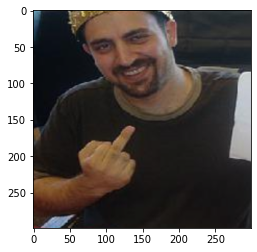

In [13]:
img = Image.open('159.250px-Maddoxtacoma.jpg')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)
images = image_to_tensor

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )
#plt.savefig('unblurred_survey.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


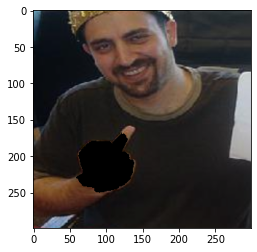

In [14]:
example_10 = get_grayscale_grad_cam(image = images)
seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 8)
features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
ranked = image_rankings(get_image_versions = ex_1)
plt.imshow(ranked[0][0].detach().cpu().squeeze().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


256
0.17086962039003362
4443
89401
tensor(-2.1179, device='cuda:0')
[0.12117218971252441, 0.8788277506828308]
0.8788277506828308


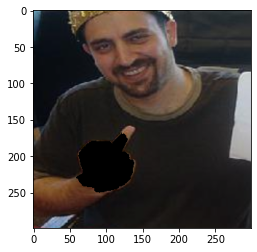

In [15]:
print(len(ranked))
index = 0
example = ranked[index][0]
print(ranked[index][3])
print(ranked[index][1])
print(ranked[index][2])
exam_img = good_img_transform(example)
print(exam_img.min())
logits = model(exam_img).cpu()
probs = F.softmax(logits, dim=1)
probs = probs.detach().cpu()
probs = probs.tolist()[0]
print(probs)
print(probs[1])
plt.imshow( example.detach().cpu().squeeze().permute(1, 2, 0)  )

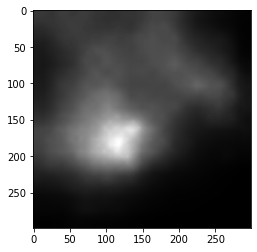

In [16]:
from pytorch_grad_cam import FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
input_tensor = images.to(device)
targets = [ClassifierOutputTarget(0)]
target_layers = [model.layer4[-1]]
cam = FullGrad(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
#visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=T
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

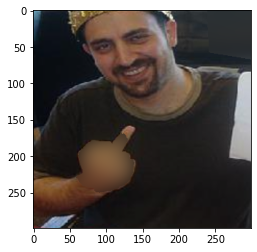

In [17]:
total_attribution =    features_1[5] + features_1[6]
blurred = cv2.GaussianBlur(images.squeeze().cpu().permute(1, 2, 0).numpy(), (91, 91), 0)
    
mask = [total_attribution, total_attribution, total_attribution]
mask = np.array(mask)
mask = mask.transpose(1,2,0)

partial_blur = np.where(mask==np.array([0, 0, 0]), images.squeeze().cpu().permute(1, 2, 0).numpy(), blurred)

# obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
#                                                        attribution_map = total_attribution)

partial_blur = torch.tensor(partial_blur)
partial_blur = partial_blur.permute(2,0,1)
partial_blur = partial_blur.unsqueeze(0)
partial_blur = invTrans(partial_blur)
plt.imshow(partial_blur.detach().cpu().squeeze().permute(1, 2, 0) )

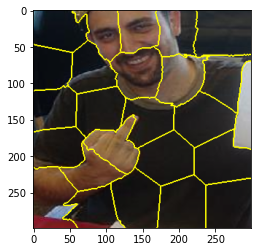

In [35]:
inv_img = invTrans(images)
img_np = inv_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = slic(img_np, n_segments=30, compactness=50,
                     start_label=1)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

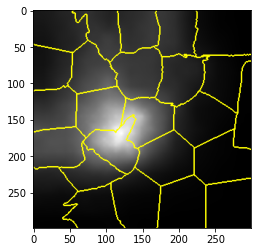

In [36]:
plt.imshow(segmentation.mark_boundaries(grayscale_cam, segments_slic))

In [18]:
for i in range(len(avg_attr_scores)):
    print(avg_attr_scores[i])

[1, 0.0, 3437, 89401]
[2, 0.0054475726, 3652, 89401]
[3, 0.0048407097, 4111, 89401]
[4, 0.20888677, 3494, 89401]
[5, 0.037536014, 3717, 89401]
[6, 0.0117664235, 3050, 89401]
[7, 0.0020815406, 3623, 89401]
[8, 1.769315e-05, 2968, 89401]
[9, 0.2068036, 3571, 89401]
[10, 0.26578358, 3557, 89401]
[11, 0.014330698, 2674, 89401]
[12, 0.028096264, 3571, 89401]
[13, 0.10798924, 3695, 89401]
[14, 0.006593837, 3310, 89401]
[15, 0.10552, 3630, 89401]
[16, 0.00050722586, 3325, 89401]
[17, 6.570181e-05, 3299, 89401]
[18, 0.023732753, 3243, 89401]
[19, 0.03115815, 4443, 89401]
[20, 0.0029955765, 3761, 89401]
[21, 0.0, 3951, 89401]
[22, 0.0, 4216, 89401]
[23, 0.0, 3871, 89401]
[24, 0.0, 4159, 89401]
[25, 0.0, 3073, 89401]


In [13]:
# To test our algorithm with no region dilation (9 regions)
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 9)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs = probs[0]
        #print(probs)
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [14]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.9666666666666667
0.12866209550228744


In [15]:
# To test our algorithm with no region dilation (7 regions)
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 7)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs = probs[0]
        #print(probs)
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [16]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.9066666666666666
0.12389771926488519


In [17]:
# To test our algorithm with no region dilation (5 regions)
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    if just_label == 0 and predicted ==0:
        print('index:', n)
        i += 1
        
        example_10 = get_grayscale_grad_cam(image = images)
        seg = segmentation_info(image = images, num_segments = 30, compactness = 50)
        avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
        top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = 5)
        features_1 = get_feature_masks(image = images, attributions = top_attrs, segments_slic = seg[1])
        ex_1 = get_image_versions(image = images, features_list = features_1, model = model, SMU_class_index = 0)
        ranked = image_rankings(get_image_versions = ex_1)
        
        
        image_info = []
        
        example = ranked[0][0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs = probs[0]
        #print(probs)
        image_info.append(probs)
        
        num_pixels_obf = ranked[0][1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

index: 12
index: 20
index: 23
index: 30
index: 37
index: 38
index: 47
index: 52
index: 57
index: 61
index: 81
index: 87
index: 90
index: 94
index: 100
index: 102
index: 104
index: 109
index: 115
index: 120
index: 123
index: 127
index: 128
index: 129
index: 138
index: 151
index: 155
index: 172
index: 174
index: 179
index: 180
index: 183
index: 185
index: 189
index: 193
index: 201
index: 218
index: 222
index: 226
index: 242
index: 243
index: 246
index: 248
index: 257
index: 271
index: 292
index: 299
index: 304
index: 312
index: 316
index: 317
index: 324
index: 332
index: 343
index: 344
index: 359
index: 362
index: 370
index: 380
index: 390
index: 391
index: 392
index: 412
index: 414
index: 417
index: 425
index: 428
index: 433
index: 437
index: 439
index: 443
index: 444
index: 453
index: 459
index: 464
index: 466
index: 474
index: 481
index: 484
index: 485
index: 486
index: 489
index: 494
index: 500
index: 502
index: 511
index: 515
index: 516
index: 521
index: 522
index: 527
index: 542
in

In [18]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
for i in range(len(image_info_list)):
    if image_info_list[i][0] < 0.5:
        success += 1
    total_obf += image_info_list[i][1] 

print(success / total)
print(total_obf / total_pix)

0.7066666666666667
0.1141772463395264
